In [218]:
#Import
import numpy as np
import tensorflow as tf
import random
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
#np.set_printoptions(threshold=np.nan)

from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('mnist-data')
data1 = input_data.read_data_sets('mnist-fashion')

#Dataset
#mnist = tf.contrib.learn.datasets.load_dataset("mnist")
#train_data = data.train.images# Returns np.array
#train_labels = np.asarray(data.train.labels, dtype=np.int32)
#test_data = data.test.images # Returns np.array
#test_labels = np.asarray(data.test.labels, dtype=np.int32)

train_data = np.concatenate((data.train.images, data1.train.images), axis=0) # Returns np.array
train_labels = np.concatenate((np.asarray(data.train.labels, dtype=np.int32), np.asarray(data1.train.labels, dtype=np.int32)))
 
print(len(train_data))

Extracting mnist-data\train-images-idx3-ubyte.gz
Extracting mnist-data\train-labels-idx1-ubyte.gz
Extracting mnist-data\t10k-images-idx3-ubyte.gz
Extracting mnist-data\t10k-labels-idx1-ubyte.gz
Extracting mnist-fashion\train-images-idx3-ubyte.gz
Extracting mnist-fashion\train-labels-idx1-ubyte.gz
Extracting mnist-fashion\t10k-images-idx3-ubyte.gz
Extracting mnist-fashion\t10k-labels-idx1-ubyte.gz
110000


In [2]:
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))
def bias_variable(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

In [3]:
def next_batch(num, data):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]

    return np.asarray(data_shuffle)

In [263]:
x = tf.placeholder(tf.float32, [None, 784])

W_1 = weight_variable([784, 196])
b_1 = bias_variable([196])

h_1 = tf.nn.relu(tf.matmul(x, W_1) + b_1)

W_2 = weight_variable([196, 49])
b_2 = bias_variable([49])

h_2 = tf.nn.relu(tf.matmul(h_1, W_2) + b_2)

W_3 = weight_variable([49, 3])
b_3 = bias_variable([3])

#z = tf.nn.relu(tf.matmul(h_2, W_3) + b_3)

z_mean = tf.matmul(h_2, W_3) + b_3
z_log_sigma_sq = tf.matmul(h_2, W_3)+ b_3

eps = tf.random_normal(shape=tf.shape(z_log_sigma_sq), mean=0, stddev=1, dtype=tf.float32)
sigma = tf.sqrt(tf.exp(z_log_sigma_sq))
z = z_mean + tf.multiply(sigma, eps)

W_4 = tf.transpose(W_3)
b_4 = bias_variable([49])

h_4 = tf.nn.relu(tf.matmul(z, W_4) + b_4)

W_5 = tf.transpose(W_2)
b_5 = bias_variable([196])

h_5 = tf.nn.relu(tf.matmul(h_4, W_5) + b_5)

W_6 = tf.transpose(W_1)
b_6 = bias_variable([784])

y =  tf.nn.sigmoid(tf.matmul(h_5, W_6) + b_6)


reconstr_loss = -tf.reduce_sum(x * tf.log(1e-10 + y) + (1-x) * tf.log(1e-10 + 1 - y),1)
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1)
cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
#cost = tf.reduce_mean(reconstr_loss)
        # Use ADAM optimizer
lr = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

In [264]:
init = tf.global_variables_initializer()

sess = tf.InteractiveSession()
sess.run(init)

saver = tf.train.Saver()

losses = []

In [289]:
#Load the model
saver.restore(sess, "./tf-models/mnist-data-autoencoder.ckpt")

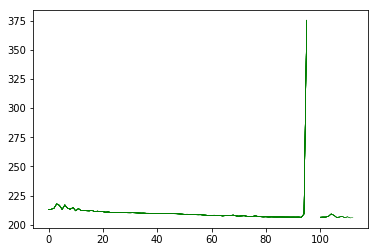

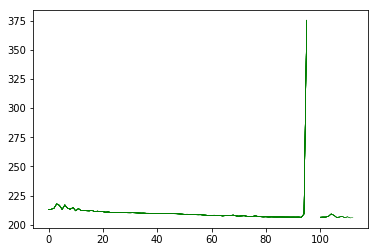

In [290]:
from IPython import display
import pandas as pd
import time
while len(losses) > 100:
    del losses[0]
try:    
    while True:
        train_batch = next_batch(10000, test_data)
        losses.append(cost.eval(feed_dict={x: train_batch}))
        plt.plot(pd.Series(data=losses), c='g', linewidth=0.5)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        train_dat = next_batch(55000, train_data)
        sess.run(optimizer, feed_dict={x: train_dat, lr: 0.003})
except KeyboardInterrupt:
    print("")
plt.show()

In [278]:
#Save the model
saver.save(sess, "./tf-models/mnist-data-autoencoder.ckpt")

'./tf-models/mnist-data-autoencoder.ckpt'

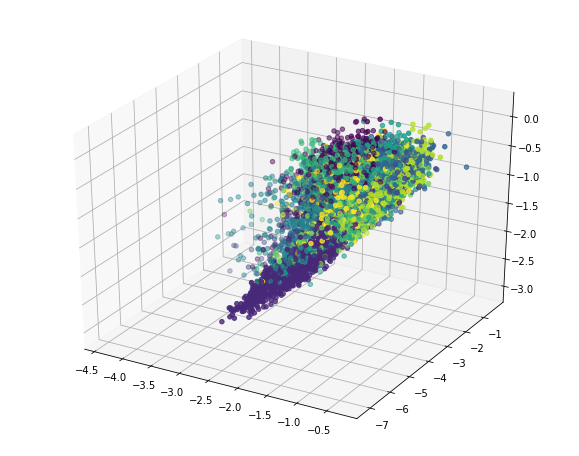

In [291]:
from mpl_toolkits.mplot3d import Axes3D
x_sample, y_sample = train_data[0:10000], train_labels[0:10000]
z_mu = sess.run(z_mean, feed_dict={x: x_sample})
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_mu[:, 0], z_mu[:, 1], z_mu[:,2], c=y_sample)
plt.show()

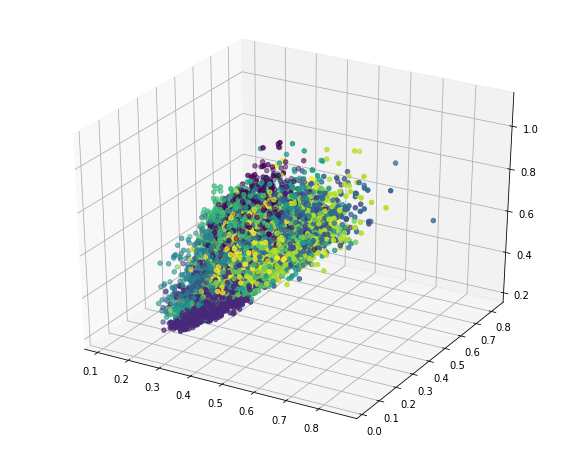

In [292]:
from mpl_toolkits.mplot3d import Axes3D
x_sample, y_sample = train_data[0:10000], train_labels[0:10000]
z_mu = sess.run(sigma, feed_dict={x: x_sample})
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_mu[:, 0], z_mu[:, 1], z_mu[:,2], c=y_sample)
plt.show()

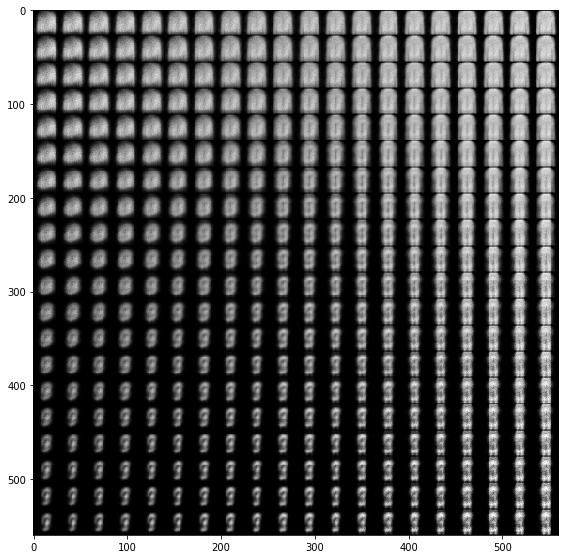

In [293]:
nx = ny = 20
x_values = np.linspace(-5, 3, nx)
y_values = np.linspace(-7, 1, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(y_values):
    for j, xi in enumerate(x_values):
        z_mu = np.array([[xi, yi, 0]]*2)
        x_mean = sess.run(y, feed_dict={z: z_mu})
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()
plt.show()

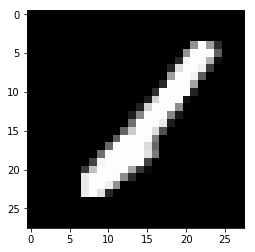

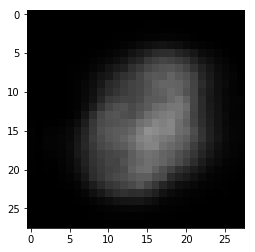

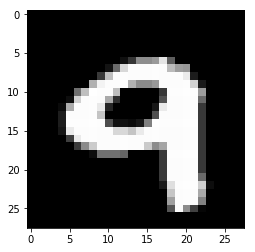

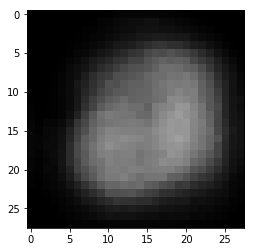

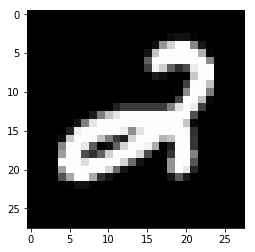

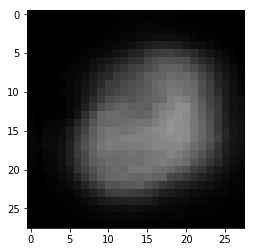

In [294]:
#num = int(input("How many pictues shall be shown?"))
num = 3
image = random.randint(0,len(train_data)-num)
res = sess.run(y, feed_dict={x: train_data[image:image+num]})

for j,e in enumerate(res):
    data = []
    for i in range(28):
        tmp = []
        for k in range(28):
            tmp.append([train_data[image+j][28*i+k-1],train_data[image+j][28*i+k-1],train_data[image+j][28*i+k-1]])
        data.append(tmp)
    dat = np.array(data, dtype=np.float32)
    plt.imshow(dat)
    plt.show()
    data = []
    for i in range(28):
        tmp = []
        for k in range(28):
            tmp.append([res[j][28*i+k-1],res[j][28*i+k-1],res[j][28*i+k-1]])
        data.append(tmp)
    dat = np.array(data, dtype=np.float32)
    plt.imshow(dat)
    plt.show()